In [ ]:
# Pip install from source
!pip install git+https://github.com/ultralytics/ultralytics@main

In [ ]:
# Git clone and run tests on updates branch
!git clone https://github.com/ultralytics/ultralytics -b main
%pip install -qe ultralytics

In [ ]:
# Run tests (Git clone only)
!pytest ultralytics/tests

In [ ]:
# Validate multiple models
for x in 'nsmlx':
  !yolo val model=yolov8{x}.pt data=coco.yaml

In [ ]:
!git clone https://github.com/jkotra/LogoNet.git



Cloning into 'LogoNet'...
remote: Enumerating objects: 133, done.
remote: Total 133 (delta 0), reused 0 (delta 0), pack-reused 133
Receiving objects: 100% (133/133), 26.33 MiB | 22.28 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
import keras
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tqdm
import os
import skimage.io
from PIL import Image
import pickle

In [ ]:
from keras.models import load_model
import pickle

def load_k_model(model_dir):
    return load_model(model_dir)

def load_labelenc(pickle_dir):
    labenc = open(pickle_dir,'rb')
    labenc = pickle.load(labenc)
    return labenc

In [ ]:
#label_encode = load_labelenc("/content/LogoNet/labels/logonet02.pickle")
model = load_k_model("/content/LogoNet/models/logonet02.h5")

<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-14-59063f58cfcf>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if h is 0 or w is 0:
<ipython-input-14-59063f58cfcf>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if h is 0 or w is 0:


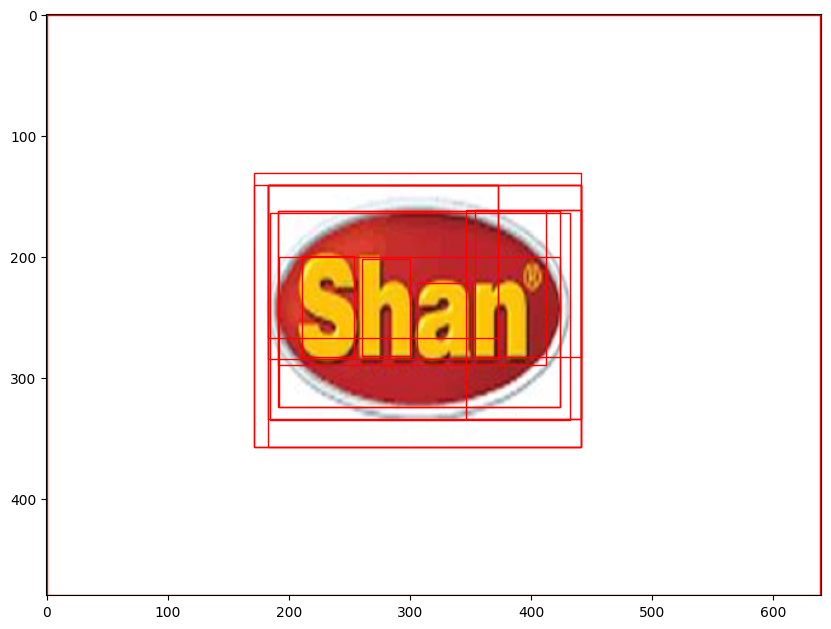

In [ ]:
import skimage.io
import selectivesearch
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

ss_arr = []

img = Image.open('/content/shan.jpeg').resize((640,480))
img = np.array(img)

img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0, min_size=500)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))

candidates = []

for r in regions:
    # excluding same rectangle (with different segments)
    if r['rect'] in candidates:
        continue
    # excluding regions smaller than 2000 pixels
    if r['size'] < 2000:
        continue
    # distorted rects
    x, y, w, h = r['rect']
    if h is 0 or w is 0:
        continue
    if w / h > 2 or h / w > 2:
        continue
    candidates.append(r['rect'])

    rect = mpatches.Rectangle((x,y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
    image = Image.fromarray(img).crop((x,y,x+w,h+y)).resize(resize_dim)
    ss_arr.append(np.array(image))

ax.imshow(img)
ss_arr = np.array(ss_arr) / 255

In [ ]:
!pip install selectivesearch

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4335 sha256=55e89ca1d74ef14a99fa730b79eb7dbfcb2b2a3e19112c54c0f8ac8322507440
  Stored in directory: /root/.cache/pip/wheels/0e/49/95/01447a4e0f48a135ac91fbdb1dd2a1c0523e40e29957b383a3
Successfully built selectivesearch


In [ ]:
import skimage.io
import selectivesearch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from keras.models import load_model
import pickle
import argparse

"""
    github = @jkotra
 """

parser = argparse.ArgumentParser()

parser.add_argument('--i', action="store", required=True)
parser.add_argument('--o', action="store", required=False)
parser.add_argument('--model', action="store", required=True)
parser.add_argument('--label', action="store", required=True)
parser.add_argument('--target', action="store", required=False)

ap = parser.parse_args()

if ap.target:
    arg_target = ap.target
else:
    arg_target = None


def pp_nd_ss(image_dir):
    global img
    ss_arr = []

    img = skimage.io.imread(image_dir)
    img = Image.fromarray(img).resize((640, 480))
    img = np.array(img)

    img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0, min_size=500)

    candidates = []

    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 2000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if h is 0 or w is 0:
            continue
        if w / h > 2 or h / w > 2:
            continue
        candidates.append(r['rect'])

        image = Image.fromarray(img).crop((x, y, x + w, h + y)).resize((64, 64))
        ss_arr.append(np.array(image))

    return ss_arr,candidates


def load_k_model(model_dir):
    return load_model(model_dir)

def load_labelenc(pickle_dir):
    labenc = open(pickle_dir,'rb')
    labenc = pickle.load(labenc)
    return labenc

def predict(model,img_array):
    print('Input Shape',img_array.shape)
    return model.predict_proba(img_array,10)


model = load_k_model(ap.model)
print("Model loaded from",ap.model)
label_encoder = load_labelenc(ap.label)
print("LabelEncoder Unpickle'd from",ap.label)
ssr,cand = pp_nd_ss(ap.i)
ssr = np.array(ssr) / 255
prediction = predict(model,ssr)


def max_predict(predictions,cand,label_encoder,target_list,api=False):
    prediction_result = []
    prediction_prob = []

    target_flag = False

    if target_list is not None:
        target_flag = True

    for pred in predictions:
        if target_flag:
            if label_encoder.inverse_transform([np.argmax(pred,axis=0)])[0] in target_list:
                prediction_prob.append(pred.max())
                prediction_result.append(label_encoder.inverse_transform([np.argmax(pred,axis=0)]))
        if target_flag == False:
            prediction_prob.append(pred.max())
            prediction_result.append(label_encoder.inverse_transform([np.argmax(pred,axis=0)]))

    max_prob = prediction_prob.index(max(prediction_prob))
    if api is True:
        x,y,w,h = cand[max_prob]
        return {
        'prediction': prediction_result[max_prob][0],
        'probability': str(max(prediction_prob)),

        'bbox': {'resize_canvas': '640x480','xywh': {
                'x': str(x),
                'y': str(y),
                'w': str(w),
                'h': str(h),
                 }
                 }
                 }
    else:
        return prediction_result,prediction_prob,max_prob,cand


prediction_result,prediction_prob,max_prob,cand = max_predict(prediction,cand,label_encoder,arg_target)

print(prediction_result[max_prob],'=>',max(prediction_prob))

x,y,h,w = cand[max_prob]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
rect = mpatches.Rectangle((x,y), w, h, fill=False, edgecolor='red', linewidth=1)
ax.add_patch(rect)
ax.text(
            x,
            y,
    "{} - {}".format(prediction_result[max_prob],max(prediction_prob)),
            fontsize=13,
bbox=dict(facecolor='blue', alpha=0.7))

ax.imshow(img)
plt.show()


In [ ]:
import skimage.io
import selectivesearch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from keras.models import load_model
import pickle

# Please upload the required files: model.h5, label_encoder.pkl, and the image file directly in Colab.

# Set the paths for uploaded files
image_path = '/content/LogoNet/images/dhltruck.jpeg'  # Change to the actual name of your uploaded image
model_path = '/content/LogoNet/models/logonet02.h5'             # Change to the actual name of your uploaded model file
label_encoder_path = '/content/LogoNet/labels/logonet02.pickle'  # Change to the actual name of your uploaded label encoder file

def pp_nd_ss(image):
    global img
    ss_arr = []

    img = image
    img = Image.fromarray(img).resize((640, 480))
    img = np.array(img)

    img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0, min_size=500)

    candidates = []

    for r in regions:
        if r['rect'] in candidates:
            continue
        if r['size'] < 2000:
            continue
        x, y, w, h = r['rect']
        if h == 0 or w == 0:
            continue
        if w / h > 2 or h / w > 2:
            continue
        candidates.append(r['rect'])

        image = Image.fromarray(img).crop((x, y, x + w, h + y)).resize((64, 64))
        ss_arr.append(np.array(image))

    return ss_arr, candidates

def load_k_model(model_dir):
    return load_model(model_dir)

def load_labelenc(pickle_dir):
    with open(pickle_dir, 'rb') as f:
        labenc = pickle.load(f)
    return labenc

def predict(model, img_array):
    print('Input Shape', img_array.shape)
    return model.predict_proba(img_array, 10)

# Load the model and label encoder
model = load_k_model(model_path)
print("Model loaded from", model_path)
label_encoder = load_labelenc(label_encoder_path)
print("LabelEncoder Unpickle'd from", label_encoder_path)

# Load the image
img = skimage.io.imread(image_path)
ssr, cand = pp_nd_ss(img)
ssr = np.array(ssr) / 255
prediction = predict(model, ssr)

def max_predict(predictions, cand, label_encoder, target_list=None, api=False):
    prediction_result = []
    prediction_prob = []

    target_flag = False

    if target_list is not None:
        target_flag = True

    for pred in predictions:
        if target_flag:
            if label_encoder.inverse_transform([np.argmax(pred, axis=0)])[0] in target_list:
                prediction_prob.append(pred.max())
                prediction_result.append(label_encoder.inverse_transform([np.argmax(pred, axis=0)]))
        if not target_flag:
            prediction_prob.append(pred.max())
            prediction_result.append(label_encoder.inverse_transform([np.argmax(pred, axis=0)]))

    max_prob = prediction_prob.index(max(prediction_prob))
    if api is True:
        x, y, w, h = cand[max_prob]
        return {
            'prediction': prediction_result[max_prob][0],
            'probability': str(max(prediction_prob)),
            'bbox': {'resize_canvas': '640x480', 'xywh': {
                'x': str(x),
                'y': str(y),
                'w': str(w),
                'h': str(h),
            }
            }
        }
    else:
        return prediction_result, prediction_prob, max_prob, cand

prediction_result, prediction_prob, max_prob, cand = max_predict(prediction, cand, label_encoder)
print(prediction_result[max_prob], '=>', max(prediction_prob))

x, y, h, w = cand[max_prob]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
ax.add_patch(rect)
ax.text(
    x,
    y,
    "{} - {}".format(prediction_result[max_prob], max(prediction_prob)),
    fontsize=13,
    bbox=dict(facecolor='blue', alpha=0.7))

ax.imshow(img)
plt.show()


Model loaded from /content/LogoNet/models/logonet02.h5


ModuleNotFoundError: No module named 'sklearn.preprocessing.label'

In [ ]:
!git clone https://github.com/nuwandda/yolov7-logo.git

Cloning into 'yolov7-logo'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 175 (delta 48), reused 74 (delta 25), pack-reused 71
Receiving objects: 100% (175/175), 78.76 MiB | 35.81 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197
Receiving objects: 100% (1197/1197), 74.23 MiB | 32.51 MiB/s, done.
Resolving deltas: 100% (519/519), done.


In [ ]:
!yolo predict model="/content/yolov7-logo/src/yolov7_training.pt" source='/content/shan.jpeg'

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 634, in torch_safe_load
    return torch.load(file, map_location="cpu"), file  # load
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 1014, in load
    return _load(opened_zipfile,
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 1422, in _load
    result = unpickler.load()
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 1415, in find_class
    return super().find_class(mod_name, name)
ModuleNotFoundError: No module named 'models'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 540, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-pac

In [ ]:
import torch

model = torch.hub.load('/content/yolov7-logo/src/yolov7_training.pt', 'yolov5s', force_reload=True, trust_repo=True)  # or yolov5n - yolov5x6 or custom
im = 'https://ultralytics.com/images/zidane.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
results = model(im)  # inference
results.print()

ValueError: too many values to unpack (expected 2)

In [ ]:
import torch

model = torch.hub.load(model ='/content/yolov7-logo/src/yolov7_training.pt', force_reload=True, trust_repo=True)  # or yolov5n - yolov5x6 or custom
im = 'https://ultralytics.com/images/zidane.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
results = model(im)  # inference

# Print the results dictionary
print(results)


TypeError: load() missing 1 required positional argument: 'repo_or_dir'

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = '/content/yolov7-logo/src/yolov7_training.pt'
model = torch.hub.load("WongKinYiu/yolov7","custom",f"{path}",trust_repo=True)

Using cache found in /root/.cache/torch/hub/WongKinYiu_yolov7_main
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Adding autoShape... 


In [ ]:
results = model("/content/shan.jpeg")

In [ ]:
results.pandas().xyxy

In [ ]:
import torch
from torchvision import transforms as T
from PIL import Image, ImageDraw
import requests


# Download the image
im_url = 'https://ultralytics.com/images/zidane.jpg'
im = Image.open(requests.get(im_url, stream=True).raw).convert("RGB")

# Preprocess the image
transform = T.Compose([T.ToTensor()])
im_tensor = transform(im).unsqueeze(0)

# Make predictions
results = model(im_tensor)

# Get bounding box information
bbox_info = results.pandas().xyxy[0]

# Draw bounding boxes on the image
draw = ImageDraw.Draw(im)
for _, row in bbox_info.iterrows():
    box = [int(val) for val in row[['xmin', 'ymin', 'xmax', 'ymax']].values]
    draw.rectangle(box, outline="red", width=3)

# Display the image with bounding boxes
im.show()


In [ ]:
print(bbox_info = results.pandas().xyxy)

[Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, confidence, class, name]
Index: []]


In [ ]:
import cv2
import torch
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

# Load YOLOv7 model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = '/content/yolov7-logo/src/yolov7_training.pt'
model = torch.hub.load("WongKinYiu/yolov7", "custom", f"{path}", trust_repo=True).to(device).eval()

# Function to process video and save frames based on specified interval
def process_video(video_path, save_folder_no_bbox, save_folder_with_bbox, save_folder_cropped, frame_interval=30):
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    dataset = LoadImages(source, img_size=imgsz, stride=stride)
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    old_img_w = old_img_h = imgsz
    old_img_b = 1
    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Warmup
        if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
            old_img_b = img.shape[0]
            old_img_h = img.shape[2]
            old_img_w = img.shape[3]
            for i in range(3):
                model(img, augment=opt.augment)[0]

        # Inference
        t1 = time_synchronized()
        with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
            pred = model(img, augment=opt.augment)[0]
        t2 = time_synchronized()

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
        t3 = time_synchronized()
         for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame_count += 1

        if frame_count % frame_interval == 0:
            # Perform object detection
            results = model(frame)

            # Convert results to a pandas DataFrame
            df = results.pandas().xyxy[0]

            if not df.empty:
                # Create folders if they don't exist
                Path(save_folder_no_bbox).mkdir(parents=True, exist_ok=True)
                Path(save_folder_with_bbox).mkdir(parents=True, exist_ok=True)
                Path(save_folder_cropped).mkdir(parents=True, exist_ok=True)

                # Save frame without bounding box
                cv2.imwrite(f"{save_folder_no_bbox}/frame_{frame_count}.jpg", frame)

                # Draw bounding boxes on the frame
                for index, row in df.iterrows():
                    xmin, ymin, xmax, ymax = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
                    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

                # Save frame with bounding box
                cv2.imwrite(f"{save_folder_with_bbox}/frame_{frame_count}.jpg", frame)

                # Save cropped region
                for index, row in df.iterrows():
                    xmin, ymin, xmax, ymax = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
                    cropped_region = frame[ymin:ymax, xmin:xmax]
                    cv2.imwrite(f"{save_folder_cropped}/frame_{frame_count}_bbox_{index}.jpg", cropped_region)

    cap.release()
    cv2.destroyAllWindows()

# Example usage for one video with a frame interval of 30
video_path = 'path/to/your/video.mp4'
save_folder_no_bbox = 'path/to/save/folder/no_bbox'
save_folder_with_bbox = 'path/to/save/folder/with_bbox'
save_folder_cropped = 'path/to/save/folder/cropped'

process_video(video_path, save_folder_no_bbox, save_folder_with_bbox, save_folder_cropped, frame_interval=30)


In [ ]:
video_paths = ['path/to/video1.mp4', 'path/to/video2.mp4', 'path/to/video3.mp4']
save_folders_no_bbox = ['path/to/save/folder1/no_bbox', 'path/to/save/folder2/no_bbox', 'path/to/save/folder3/no_bbox']
save_folders_with_bbox = ['path/to/save/folder1/with_bbox', 'path/to/save/folder2/with_bbox', 'path/to/save/folder3/with_bbox']
save_folders_cropped = ['path/to/save/folder1/cropped', 'path/to/save/folder2/cropped', 'path/to/save/folder3/cropped']

for video_path, save_no_bbox, save_with_bbox, save_cropped in zip(video_paths, save_folders_no_bbox, save_folders_with_bbox, save_folders_cropped):
    process_video(video_path, save_no_bbox, save_with_bbox, save_cropped)


In [ ]:
import cv2
import os

def extract_frames(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Specify the desired frame rate
    desired_frame_rate = 30

    # Calculate the interval to capture frames
    interval = int(round(fps / desired_frame_rate)) if fps != 0 else 1

    # Get the video name without extension
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    # Create the output folder using the video name
    output_folder = f"{video_name}_frames"
    os.makedirs(output_folder, exist_ok=True)

    # Initialize variables
    frame_count = 0
    success = True

    while success:
        # Set the position to the next frame to be read
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

        # Read the frame
        success, frame = cap.read()

        # Check if the current frame index is a multiple of the interval
        if frame_count % interval == 0 and success:
            # Save the frame to the output folder
            frame_filename = os.path.join(output_folder, f"frame_{frame_count // interval}.jpg")
            cv2.imwrite(frame_filename, frame)

        frame_count += 1

    # Release the video capture object
    cap.release()

    print(f"Frames extracted and saved from {video_path} in: {output_folder}")

if __name__ == "__main__":
    # Replace with your video paths
    video_paths = ['/content/Intel Logo Evolution 1971 - 2020.mp4']

    for video_path in video_paths:
        extract_frames(video_path)


Frames extracted and saved from /content/Intel Logo Evolution 1971 - 2020.mp4 in: Intel Logo Evolution 1971 - 2020_frames


In [ ]:
video_paths = ['/content/output_video.mp4']

for video_path in video_paths:
    result_folder = extract_frames(video_path)
    print(f"Frames extracted and saved from {video_path} in: {result_folder}")

ZeroDivisionError: integer division or modulo by zero

In [ ]:
import os

def get_subfolders(parent_folder):
    subfolders = [f.path for f in os.scandir(parent_folder) if f.is_dir()]
    return subfolders

# Replace 'your_parent_folder' with the path to your parent folder
parent_folder = 'your_parent_folder'

subfolders = get_subfolders(parent_folder)

print(f"Subfolders in {parent_folder}:")
for subfolder in subfolders:
    print(subfolder)

In [ ]:
import os

def get_subfolders(parent_folder):
    subfolders = [f.path for f in os.scandir(parent_folder) if f.is_dir()]
    return subfolders

conf_threshold = 0.25
weights_path = "/content/best.pt"

# Replace 'your_parent_folder' with the path to your parent folder
parent_folder = '/content/Intel Logo Evolution 1971 '

subfolders = get_subfolders(parent_folder)

if not subfolders:
    subfolders = [parent_folder]

for subfolder in subfolders:
    command = f"python src/yolov7/detect.py --source {subfolder} --weights {weights_path} --conf {conf_threshold} --name yolo_logo_det"
    output = os.popen(command).read()
    print(output)



In [ ]:
subfolders

['/content/Intel Logo Evolution 1971 ']

In [ ]:
from pytube import YouTube

def Download(link):
    youtubeObject = YouTube(link)
    youtubeObject = youtubeObject.streams.get_highest_resolution()
    try:
        youtubeObject.download()
    except:
        print("An error has occurred")
    print("Download is completed successfully")


link = input("https://youtu.be/5yPJAmI9Rng")
Download(link)

https://youtu.be/5yPJAmI9Rnghttps://youtu.be/5yPJAmI9Rng
Download is completed successfully


In [ ]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 910.3 kB/s eta 0:00:00


Frames extracted and saved in: /content/output_video_frames
Frames extracted and saved in: /content/Intel Logo Evolution 1971 - 2020_frames


In [ ]:
!python /content/yolov7/detect.py --source /content/shan.jpeg  --weights content/best.pt --conf 0.25 --name yolo_logo_det!

Namespace(weights=['content/best.pt'], source='/content/shan.jpeg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='yolo_logo_det!', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.1.0+cu121 CUDA:0 (Tesla T4, 15102.0625MB)

fatal: not a git repository (or any of the parent directories): .git
Traceback (most recent call last):
  File "/content/yolov7/utils/google_utils.py", line 26, in attempt_download
    assets = [x['name'] for x in response['assets']]  # release assets
KeyError: 'assets'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/yolov7/detect.py", line 196, in <module>
    detect()
  File "/content/yolov7/detect.py", line 34, in detect
    model = attempt_load(weights, map_location=device)  # load FP32 model
  File "/content/

In [ ]:
print(results)

In [ ]:
results.pandas().xyxy

[         xmin       ymin        xmax        ymax  confidence  class   name
 0  229.798096  40.449554  1009.32373  551.342529    0.732426     12  Intel]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd

# Example results
results_data = {
    'xmin': [229.798096],
    'ymin': [40.449554],
    'xmax': [1009.32373],
    'ymax': [551.342529],
    'confidence': [0.732426],
    'class': [12],
    'name': ['Intel']
}

# Convert results to a DataFrame
results_df = pd.DataFrame(results_data)

# Load the image (replace 'your_image_path.jpg' with the actual image path)
image_path = 'your_image_path.jpg'
image = Image.open(image_path)

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Draw bounding boxes
for index, row in results_df.iterrows():
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='r', facecolor='none', label=row['name'])
    ax.add_patch(rect)

    # Annotate with class name and confidence
    label = f"{row['name']} {row['confidence']:.2f}"
    ax.text(xmin, ymin - 5, label, color='r', fontsize=8, verticalalignment='top')

# Show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'your_image_path.jpg'

In [ ]:
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel
weights = "/content/best.pt"
imgsz = 640
img_size = 640
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
half = device.type != 'cpu'  # half precision only supported on CUDA

# Load model
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(imgsz, s=stride)  # check img_size
source = "/content/yolov7-logo/images"
dataset = LoadImages(source, img_size=imgsz, stride=stride)
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
device.type
trace = True
if trace:
      model = TracedModel(model, device, img_size)
if half:
        model.half()

classify = False
if classify:
    modelc = load_classifier(name='resnet101', n=2)  # initialize
    modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()
conf_thres = 0.25
if device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
old_img_w = old_img_h = imgsz
old_img_b = 1

t0 = time.time()
for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Warmup
    if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
        old_img_b = img.shape[0]
        old_img_h = img.shape[2]
        old_img_w = img.shape[3]
        for i in range(3):
            model(img, augment=False)[0]

    # Inference

    with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
        pred = model(img,augment = False)[0]


    # Apply NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres = 0.45, classes=None, agnostic=True)
    t3 = time_synchronized()
for i, det in enumerate(pred):
  p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)
save_dir = Path("/content/sample_data")
p = Path(p)  # to Path
save_path = str(save_dir / p.name)  # img.jpg
txt_path = str(save_dir / 'labels' / p.stem) + ('')  # img.txt
gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
if len(det):
    # Rescale boxes from img_size to im0 size
    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

    # Print results
    for c in det[:, -1].unique():
        n = (det[:, -1] == c).sum()  # detections per class
        s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
# Process detections
for i, det in enumerate(pred):  # detections per image

    p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)
    save_dir = Path("/content/sample_data")
    p = Path(p)  # to Path
    save_path = str(save_dir / p.name)  # img.jpg
    txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
    gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

        # Print results
        for c in det[:, -1].unique():
            n = (det[:, -1] == c).sum()  # detections per class
            s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

        # Write results
        for *xyxy, conf, cls in reversed(det):
          label = f'{names[int(cls)]} {conf:.2f}'
          plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=10)

    # Print time (inference + NMS)
    print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')

    # Stream results
    cv2.imwrite(save_path, im0)


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

Done. (17.9ms) Inference, (557958.8ms) NMS


In [ ]:
!python /content/yolov7/detect.py --source /content/yolov7-logo/data/Sample/test --weights /content/best.pt --conf 0.25 --name yolo_logo_det

Namespace(weights=['/content/best.pt'], source='/content/yolov7-logo/data/Sample/test', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='yolo_logo_det', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.1.0+cu121 CUDA:0 (Tesla T4, 15102.0625MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36622016 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
1 

In [ ]:
import os
from pathlib import Path
from PIL import Image
import torch
from tqdm import tqdm
from torchvision.transforms import functional as F
from yolov7.utils.general import non_max_suppression, scale_coords

def get_detections(model, image, img_size=640, conf_thres=0.25, iou_thres=0.45):
    # Perform inference with YOLOv7 model
    img_tensor = F.to_tensor(image).unsqueeze(0)
    img_tensor = img_tensor.to(device)
    results = model(img_tensor)

    # Post-process detections
    results = non_max_suppression(results, conf_thres=conf_thres, iou_thres=iou_thres)

    return results[0] if results[0] is not None else []

def draw_boxes(image, detections):
    # Draw bounding boxes on the image
    for det in detections:
        xmin, ymin, xmax, ymax, conf, class_idx = det
        class_name = model.names[int(class_idx)]

        # Assuming 'image' is a PIL Image
        draw = ImageDraw.Draw(image)
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        draw.text((xmin, ymin - 10), f"{class_name} {conf:.2f}", fill="red", font=None)
        del draw

    return image

def process_images(input_folder, output_folder, model):
    # Create output folders
    original_folder = os.path.join(output_folder, 'original')
    bbox_folder = os.path.join(output_folder, 'with_bbox')

    for folder in [original_folder, bbox_folder]:
        os.makedirs(folder, exist_ok=True)

    # Process each image in the input folder
    for image_filename in tqdm(os.listdir(input_folder)):
        if image_filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust based on your image extensions
            image_path = os.path.join(input_folder, image_filename)
            original_image = Image.open(image_path).convert("RGB")

            # Get detections for the current image
            detections = get_detections(model, original_image)

            if detections:
                # Save original image
                original_image.save(os.path.join(original_folder, image_filename))

                # Draw bounding boxes on the image
                image_with_bbox = draw_boxes(original_image.copy(), detections)
                image_with_bbox.save(os.path.join(bbox_folder, image_filename))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load YOLOv7 model
path = "/content/best.pt"  # Replace with the actual path to your YOLOv7 model
model = torch.hub.load("WongKinYiu/yolov7", "custom", path, trust_repo=True).to(device).eval()

# Example usage:
input_folder_path = "/content/Intel"
output_folder_path = "/content/sample_data"
process_images(input_folder_path, output_folder_path, model)


Using cache found in /root/.cache/torch/hub/WongKinYiu_yolov7_main


Adding autoShape... 


  0%|          | 0/29 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 85 but got size 84 for tensor number 1 in the list.

In [ ]:
import os
from pathlib import Path
import pandas as pd
from PIL import Image
import cv2
from numpy import ndarray
from typing import List
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def process_images(input_folder, output_folder):
    # Create output folders
    original_folder = os.path.join(output_folder, 'original')
    bbox_folder = os.path.join(output_folder, 'with_bbox')
    cropped_folder = os.path.join(output_folder, 'cropped')

    for folder in [original_folder, bbox_folder, cropped_folder]:
        os.makedirs(folder, exist_ok=True)

    # Process each image in the input folder
    for image_filename in os.listdir(input_folder):
        if image_filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust based on your image extensions
            image_path = os.path.join(input_folder, image_filename)
            image: ndarray = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            results = model(image_path)
            resultbbxx = results.pandas().xyxy
            for index, row in results.iterrows():
              xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
              confidence, class_name = row['confidence'], row['name']
              cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
              text = f"{class_name}: {confidence:.2f}"
              cv2.putText(image, text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Extract detection information for the current image
              # Replace with your method to get detections
        else:
          print(f"No detections for {image_filename}")

    # Check if the folder is empty
    if not os.listdir(input_folder):
        print("The input folder is empty.")

def get_detections(image_filename):
    # Replace this function with your method to get detections based on image_filename
    # For example, filter results.pandas().xyxy based on the image_filename
    # and return a DataFrame with detections for that image.
    # Here, I'm assuming results is a global variable representing the detection results.
    return results[results['name'] == image_filename]

def draw_boxes(image, detections):
    # Implement drawing bounding boxes on the image based on the detection DataFrame
    # and return the modified image
    # You can use PIL or other libraries to draw bounding boxes.
    # Example using PIL:
    # draw = ImageDraw.Draw(image)
    # for _, row in detections.iterrows():
    #     xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    #     draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
    # del draw
    return image

def save_cropped_images(image, detections, output_folder, image_filename):
    # Implement saving cropped images based on the detection DataFrame
    # and the original image
    # Example using PIL:
    # for i, row in detections.iterrows():
    #     xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    #     cropped_image = image.crop((xmin, ymin, xmax, ymax))
    #     cropped_image.save(os.path.join(output_folder, f"cropped_{i}_{image_filename}"))

# Example usage:
input_folder_path = "/path/to/your/input/folder"
output_folder_path = "/path/to/your/output/folder"
process_images(input_folder_path, output_folder_path)


In [ ]:
[         xmin       ymin        xmax        ymax  confidence  class   name
 0  229.798096  40.449554  1009.32373  551.342529    0.732426     12  Intel]

In [ ]:
results.pandas().xyxy

[         xmin       ymin        xmax        ymax  confidence  class   name
 0  229.798096  40.449554  1009.32373  551.342529    0.732426     12  Intel]

In [ ]:
import cv2
import pandas as pd

# Assuming results.pandas().xyxy() returns the DataFrame with bounding box information
results =  # Get your results here

# Read the image
image_path = 'path/to/your/image.jpg'
image = cv2.imread(image_path)

# Draw bounding box on the image
for index, row in results.iterrows():
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    confidence, class_name = row['confidence'], row['name']

    # Draw rectangle
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # Display class and confidence
    text = f"{class_name}: {confidence:.2f}"
    cv2.putText(image, text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show the image with bounding boxes
cv2.imshow('Image with Bounding Boxes', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import os
import cv2
import pandas as pd

def process_images(input_folder, output_folder):
    # Create output folders
    original_folder = os.path.join(output_folder, 'original')
    bbox_folder = os.path.join(output_folder, 'with_bbox')
    cropped_folder = os.path.join(output_folder, 'cropped')

    for folder in [original_folder, bbox_folder, cropped_folder]:
        os.makedirs(folder, exist_ok=True)

    # Process each image in the input folder
    for image_filename in os.listdir(input_folder):
        if image_filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust based on your image extensions
            image_path = os.path.join(input_folder, image_filename)
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # Save the original image to the 'original' folder
            original_output_path = os.path.join(original_folder, image_filename)
            cv2.imwrite(original_output_path, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

            # Process the image with the model
            results = model(image_path)
            resultbbxx = results.pandas().xyxy

            # Draw bounding boxes on the image
            for index, row in resultbbxx[0].iterrows():
                xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
                confidence, class_name = row['confidence'], row['name']

                # Draw bounding boxes on the original image
                cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                text = f"{class_name}: {confidence:.2f}"
                cv2.putText(original_image, text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Save the image with bounding boxes to the 'with_bbox' folder
                bbox_output_filename = f"{class_name}_{image_filename}"
                bbox_output_path = os.path.join(bbox_folder, bbox_output_filename)
                cv2.imwrite(bbox_output_path, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

                # Crop the region of interest and save to the 'cropped' folder
                cropped_image = original_image[ymin:ymax, xmin:xmax]
                cropped_output_filename = f"{class_name}_cropped_{image_filename}"
                cropped_output_path = os.path.join(cropped_folder, cropped_output_filename)
                cv2.imwrite(cropped_output_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
        else:
            print(f"No detections for {image_filename}")

# Replace 'path/to/your/input/folder' with the path to your input images
# Replace 'path/to/your/output/folder' with the desired output folder
process_images('/content/yolov7-logo/data/Sample/test', 'ontent')


In [ ]:
x = results.pandas().xyxy

In [ ]:
x[0].iterrows()

<generator object DataFrame.iterrows at 0x7a9e66a4b990>

In [ ]:
import cv2
import os

def extract_frames(video_folder):
    # get list of video files in the folder
    video_files = [f for f in os.listdir(video_folder) if f.lower().endswith(('.mp4', '.avi', '.mkv', '.mov'))]

    # iterate over each video file in the folder
    for video_file in video_files:
        video_path = os.path.join(video_folder, video_file)

        # create an output folder with the same name as the video file (without extension)
        output_folder = os.path.splitext(video_file)[0] + '_frames'
        output_folder_path = os.path.join(video_folder, output_folder)
        os.makedirs(output_folder_path, exist_ok=True)

        # read the video and extract info about it
        cap = cv2.VideoCapture(video_path)

        # get total number of frames and generate a list with each 30th frame
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_to_extract = [i for i in range(1, total_frames) if divmod(i, 30)[1] == 0]

        for frame_number in frames_to_extract:
            # set which frame to read
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

            # read frame
            ret, frame = cap.read()

            # save frame to the output folder
            frame_filename = os.path.join(output_folder_path, f"frame_{frame_number // 30}.jpg")
            cv2.imwrite(frame_filename, frame)

        # release the video capture object
        cap.release()

        print(f"Frames extracted and saved in: {output_folder_path}")

video_folders = ['/content']

for video_folder in video_folders:
    extract_frames(video_folder)


Frames extracted and saved in: /content/Intel Logo Evolution 1971 - 2020_frames


In [ ]:
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = '/content/best.pt'
model = torch.hub.load("WongKinYiu/yolov7","custom",f"{path}",trust_repo=True)

results = model("/content/Intel Logo Evolution 1971 - 2020_frames/frame_19.jpg")

In [ ]:
import os
import cv2
import pandas as pd

def process_images(input_folder, output_folder):
    # Create output folders
    original_folder = os.path.join(output_folder, 'original')
    bbox_folder = os.path.join(output_folder, 'with_bbox')
    cropped_folder = os.path.join(output_folder, 'cropped')

    for folder in [original_folder, bbox_folder, cropped_folder]:
        os.makedirs(folder, exist_ok=True)

    # Process each image in the input folder
    for image_filename in os.listdir(input_folder):
        if image_filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust based on your image extensions
            image_path = os.path.join(input_folder, image_filename)
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # Save the original image to the 'original' folder
            original_output_path = os.path.join(original_folder, image_filename)
            #cv2.imwrite(original_output_path, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

            # Process the image with the model
            results = model(image_path)
            resultbbxx = results.pandas().xyxy

            # Check if there are valid results in the 'name' column
            if not resultbbxx[0].empty:
                # Draw bounding boxes on the image
                for index, row in resultbbxx[0].iterrows():
                    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
                    confidence, class_name = row['confidence'], row['name']

                    # Draw bounding boxes on the original image
                    cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                    text = f"{class_name}: {confidence:.2f}"
                    cv2.putText(original_image, text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                    # Save the image with bounding boxes to the 'with_bbox' folder
                    bbox_output_filename = f"{class_name}_{image_filename}"
                    bbox_output_path = os.path.join(bbox_folder, bbox_output_filename)
                    cv2.imwrite(bbox_output_path, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

                    # Crop the region of interest and save to the 'cropped' folder
                    cropped_image = original_image[ymin:ymax, xmin:xmax]
                    cv2.imwrite(original_output_path, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))
                    cropped_output_filename = f"{class_name}_cropped_{image_filename}"
                    cropped_output_path = os.path.join(cropped_folder, cropped_output_filename)
                    cv2.imwrite(cropped_output_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
            else:
                print(f"No valid detections for {image_filename}")
        else:
            print(f"No detections for {image_filename}")

# Replace 'path/to/your/input/folder' with the path to your input images
# Replace 'path/to/your/output/folder' with the desired output folder
process_images('/content/yolov7-logo/data/Sample/test', 'ent')


No valid detections for 4434414.jpg
No valid detections for 57857859.jpg
